In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('03/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer

In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.isnull().sum() #결측값이 없고, 모두 숫자형 데이터라서 별다른 전처리 없이 ㄱㄱ

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 본격 머신러닝! y:Outcome, X:data
- logisticregression 모델 사용, y(당뇨병 여부) 예측
- 어떠한 x값이 영향을 주었는지?

In [47]:
#데이터셋 추출
y_df = df['Outcome']
X_df = df.drop('Outcome', axis=1)

In [12]:
#split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.2, random_state=156, stratify=y_df)

In [13]:
#객체
lr_clf = LogisticRegression()
#학습
lr_clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
#예측
pred = lr_clf.predict(X_test)

In [15]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    acc=accuracy_score(y_test,pred)
    pre=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1스코어: {3:.4f}'.format(acc, pre, recall, f1))

In [16]:
#함수 적용
get_clf_eval(y_test, pred)

[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1스코어: 0.6465


In [17]:
## 이 데이터는 N이 많이 분포되어 있으므로, 정확도보다는 재현율(recall) 성능을 더 높여보자.

In [19]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]

##### precision_recall_curve() 이용

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def pre_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba) #y_test(정답) 과 pred_proba(예측값) 비교
    
    plt.figure(figsize=(12,8))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision') #x: 임곗값 , y:precision
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall') #x:임곗값, y:recall
    
    #x축 단위 0.1로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #label, legend, grid
    plt.xlabel('Threshold value')
    plt.ylabel('Precision & Recall value')
    plt.grid(True)
    plt.legend()
    plt.show()

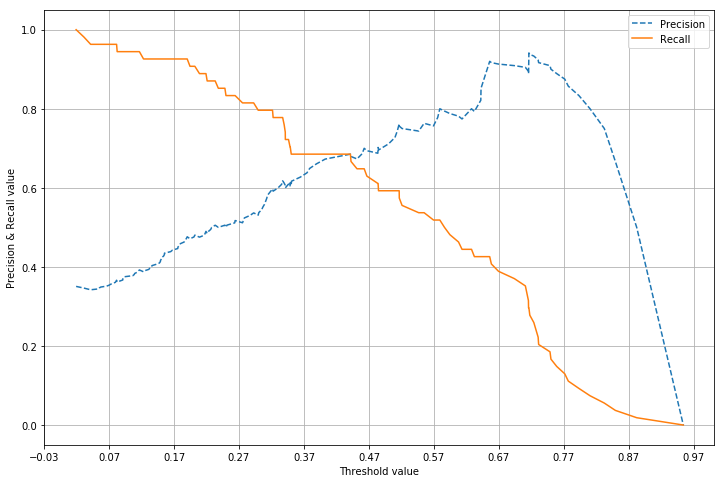

In [29]:
pre_recall_curve_plot(y_test, pred_proba_c1)

In [ ]:
#결과를 보면 두 곡선이 만나는 지점인--threshold가 0.42 정도면 딱 적당한 듯.
#그러나 0.42에서도 정밀도와 재현율 모두 0.7이 안 되는 수준. => 임곗값을 조절하기 전에 데이터 값을 점검하자.(이상치가 있을지도?)

In [30]:
df.describe() #보면 min이 0인 칼럼이 다수 존재(Glucose, bloodpressure 등..): 사실 0일 수가 없는데?->전처리.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

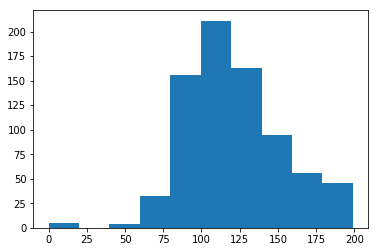

In [32]:
#히스토그램 그려보기!
plt.hist(df['Glucose'], bins=10) #역시 글루코젠이 0인 게 있구나..

In [38]:
#min이 0인 피처들에서 0 값이 몇개가 있는지 확인
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

#전체 데이터 건수(하나의 컬럼에서만 count하면 됨)
total_count = df['Glucose'].count()
total_count

768

In [42]:
#for loop를 이용, 데이터값이 0인 데이터 건수와 그 비율?
for i in zero_features:
    zero_count= df[df[i]==0][i].count()
    print('{0}// 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(i, zero_count, 100*zero_count/total_count))

Glucose// 0 건수는 5, 퍼센트는 0.65 %
BloodPressure// 0 건수는 35, 퍼센트는 4.56 %
SkinThickness// 0 건수는 227, 퍼센트는 29.56 %
Insulin// 0 건수는 374, 퍼센트는 48.70 %
BMI// 0 건수는 11, 퍼센트는 1.43 %


- 0의 건수가 생각보다 많아서 0을 다 지워버리면 ML에 문제가 있을 듯. 그러므로 0을 평균값으로 대치하자

In [45]:
mean_zero_features = df[zero_features].mean()
df[zero_features]= df[zero_features].replace(0, mean_zero_features) #replace(a,b)는 a를 b로 대체.

In [67]:
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

In [46]:
for i in zero_features:
    zero_count= df[df[i]==0][i].count()
    print('{0}// 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(i, zero_count, 100*zero_count/total_count))

Glucose// 0 건수는 0, 퍼센트는 0.00 %
BloodPressure// 0 건수는 0, 퍼센트는 0.00 %
SkinThickness// 0 건수는 0, 퍼센트는 0.00 %
Insulin// 0 건수는 0, 퍼센트는 0.00 %
BMI// 0 건수는 0, 퍼센트는 0.00 %


- 다시 시작!

In [48]:
#혹은 다른 방식으로
y_df = df.iloc[:,-1]
X_df = df.iloc[:, :-1]

In [49]:
##이번엔 standardscaler로 표준화!(X의 데이터들이 전부 숫자형이므로, 범주형도 없고(연속형만))
scaler = StandardScaler()
scaler.fit(X_df)
X_scaled = scaler.transform(X_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [50]:
#split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, test_size=.2, random_state=156, stratify=y_df)

In [51]:
#객체
lr_clf = LogisticRegression()
#학습
lr_clf.fit(X_train, y_train)
#예측
pred = lr_clf.predict(X_test)

#함수 적용
get_clf_eval(y_test, pred)

[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1스코어: 0.6804


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 데이터 전처리를 하고, 스케일링으로 정규화를 하니 성능 수치가 일정 수준 개선되었다.
#하지만 그래도 재현율을 높이는게 목적이었으므로 threshold를 바꾸면서 재현율 추이를 살펴보자.

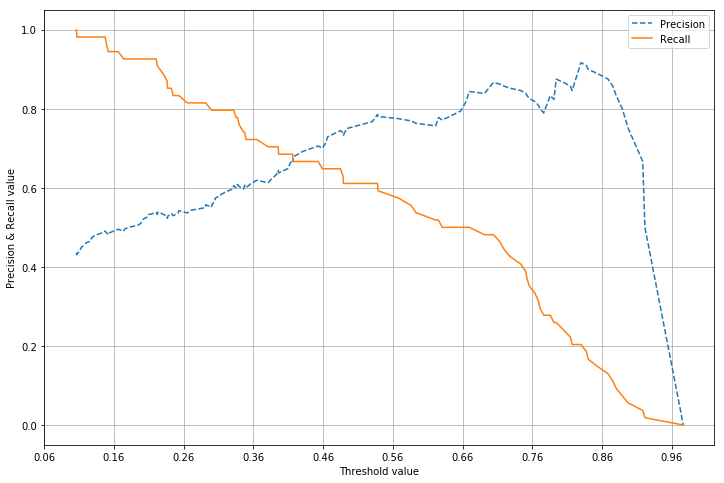

In [52]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
pre_recall_curve_plot(y_test, pred_proba_c1)

In [64]:
#ROC 곡선 시각화: fpr, tpr 값 / 사실 이 실습에서는 크게 필요가 없음
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(10,8))
    plt.plot(fprs, tprs, label='ROC') #ROC curve
    plt.plot([0,1],[0,1], 'k--', label='Random') #가운데 대각선 직선
    
    #x축 스케일 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),1))
    
    #범위, label ,legend
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

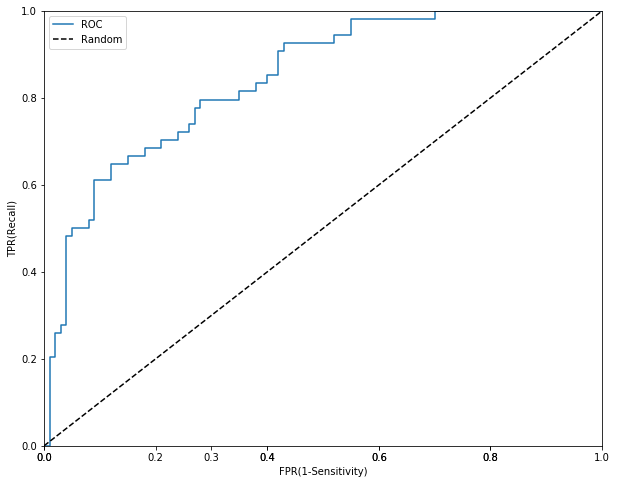

In [65]:
roc_curve_plot(y_test, pred_proba_c1) #threshold를 바꿔가면서 fpr에 따른 tpr그래프

In [61]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    acc=accuracy_score(y_test,pred)
    pre=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred)
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1스코어: {3:.4f}, AUC스코어: {4:.4f}'.format(acc, pre, recall, f1,roc_auc))

In [62]:
def get_eval_by_threshold(pred_proba_class, y_test):
    thresholds=[0.3, 0.33, 0.36, 0.39, 0.42, 0.48, 0.5] #threshold를 0.3~0.5 사이로만 넣음
    pred_proba = pred_proba_class.reshape(-1,1) #요기서는 reshape 필요
    for i in thresholds:
        binarizer=Binarizer(threshold=i).fit(pred_proba) #학습
        pred = binarizer.transform(pred_proba) #예측
        print('\n threshold는 : ', i)
        get_clf_eval(y_test, pred)

In [63]:
get_eval_by_threshold(pred_proba_c1, y_test)


 threshold는 :  0.3
[[65 35]
 [11 43]]
정확도: 0.7013, 정밀도: 0.5513, 재현율: 0.7963, F1스코어: 0.6515, AUC스코어: 0.7231

 threshold는 :  0.33
[[71 29]
 [11 43]]
정확도: 0.7403, 정밀도: 0.5972, 재현율: 0.7963, F1스코어: 0.6825, AUC스코어: 0.7531

 threshold는 :  0.36
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1스코어: 0.6667, AUC스코어: 0.7411

 threshold는 :  0.39
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1스코어: 0.6667, AUC스코어: 0.7419

 threshold는 :  0.42
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1스코어: 0.6792, AUC스코어: 0.7533

 threshold는 :  0.48
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1스코어: 0.6931, AUC스코어: 0.7641

 threshold는 :  0.5
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1스코어: 0.6804, AUC스코어: 0.7556


#### 최종 확정된 threshold = 0.48 로만 결과를 도출하면(함수 쓸필요 x)

In [66]:
pred_proba = pred_proba_c1.reshape(-1,1)

binarizer=Binarizer(threshold=0.48).fit(pred_proba) #학습
pred = binarizer.transform(pred_proba) #예측
get_clf_eval(y_test, pred)

[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1스코어: 0.6931, AUC스코어: 0.7641
